# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math

# Set Hyperparameters

In [2]:
INPUT_SHAPE = 28
INPUT_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
CHANNELS = 1

# Load Data

In [3]:
train_dataset = datasets.MNIST(root = "dataset/", train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = "dataset/", train = False, transform = transforms.ToTensor(), download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

# Create the Network

In [5]:
class SimpleCNN(nn.Module) : 
  def __init__(self, channels, input_size, n_classes) :
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(channels, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # same convolution
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # size becomes half
    self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # same convolution
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # size becomes half
    self.fc1 = nn.Linear(16*int(math.ceil(input_size//4))*int(math.ceil(input_size//4)), 32)
    self.fc2 = nn.Linear(32, n_classes)
  
  def forward(self, x) : 
    x = torch.relu(self.conv1(x))
    x = self.pool1(x)
    x = torch.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.reshape(x.shape[0], -1)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [6]:
# TEST MODEL

T_INPUT_SHAPE = 32
T_INPUT_CLASSES = 10
T_CHANNELS = 1
T_BATCH_SIZE = 64

test_model = SimpleCNN(T_CHANNELS, T_INPUT_SHAPE, T_INPUT_CLASSES)
x = torch.randn(T_BATCH_SIZE, T_CHANNELS, T_INPUT_SHAPE, T_INPUT_SHAPE)
res = tuple(test_model(x).shape)
assert res == (T_BATCH_SIZE, T_INPUT_CLASSES), "Model output shape wrong"

# Set Device

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


# Training

## Create Model Instance

In [8]:
model = SimpleCNN(CHANNELS, INPUT_SHAPE, INPUT_CLASSES).to(DEVICE)

## Loss Function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Accuracy

In [10]:
def accuracy(scores, targets) :
  l = targets.numel() 
  corr = np.sum(np.argmax(scores.detach().numpy(), axis=1) == targets.numpy())
  return corr/l

# Train the netwrok

In [11]:
history = {
    "train_losses" : [],
    "test_losses" : [],
    "train_accuracy" : [],
    "test_accuracy" : []
}

for epoch in range(NUM_EPOCHS) :
  train_losses = []
  test_losses = [] 
  train_acc = []
  test_acc = []

  model.train()
  for data, targets in train_loader : 
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    scores = model(data) # Get output
    loss = criterion(scores, targets) # Get loss
    optimizer.zero_grad() # Flush optimizer
    loss.backward() # Calculate gradients
    optimizer.step() # Gradient Descent
    train_losses.append(float(loss))
    train_acc.append(accuracy(scores, targets))

  model.eval()
  with torch.no_grad() :
      for t_data, t_targets in test_loader :
        t_data = t_data.to(DEVICE)
        t_targets = t_targets.to(DEVICE)
        t_scores = model(t_data) 
        t_loss = criterion(t_scores, t_targets)
        test_losses.append(float(t_loss))
        test_acc.append(accuracy(t_scores, t_targets))
  history["train_losses"].append(sum(train_losses)/len(train_losses))
  history["test_losses"].append(sum(test_losses)/len(test_losses))
  history["train_accuracy"].append(sum(train_acc)/len(train_acc))
  history["test_accuracy"].append(sum(test_acc)/len(test_acc))

# Plotting

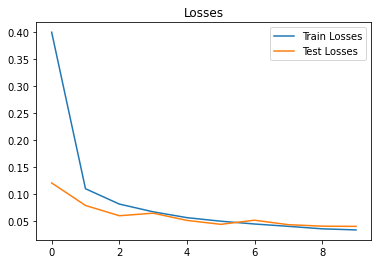

In [12]:
plt.title("Losses")
plt.plot(history["train_losses"], label="Train Losses")
plt.plot(history["test_losses"], label="Test Losses")
plt.legend()
plt.show()

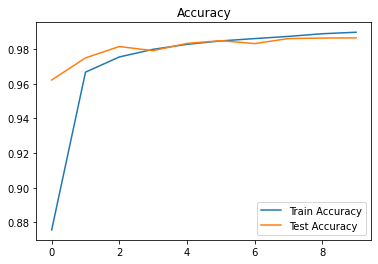

In [13]:
plt.title("Accuracy")
plt.plot(history["train_accuracy"], label="Train Accuracy")
plt.plot(history["test_accuracy"], label="Test Accuracy")
plt.legend()
plt.show()